# EDA and Sentiment Analysis on COVID-19 Tweets Data

## Load Dataset

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import preprocessor.api as p
from preprocessor.api import clean, tokenize, parse

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suyuejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
covid_tweets_data = pd.read_csv("covid19_tweets.csv")
tweets_sentiment_data = pd.read_csv("finalSentimentdata2.csv")

`covid_tweets_data` is the dataset that we want to use in this project. `tweets_sentiment_data` is another dataset that contains covid tweets and relevant sentiment as labels which we could use to train a supervised sentiment analysis model. We could also use clustering techniques to train an unsupervised sentiment analysis model but it would not be less effective.

## Describe Data

In [98]:
covid_tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [99]:
covid_tweets_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [100]:
covid_tweets_data.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


In [101]:
tweets_sentiment_data.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly thei...
1,1431,joy,if only i could have spent the with this cutie...
2,654,joy,will nature conservation remain a priority in ...
3,2530,sad,coronavirus disappearing in italy show this to...
4,2296,sad,uk records lowest daily virus death toll since...


## Exploratory Data Analysis

### Visualize Missing Values

In [102]:
missing_values = pd.DataFrame()
missing_values['column'] = covid_tweets_data.columns
missing_values['ratio'] = [
    covid_tweets_data[col].isnull().sum() / len(covid_tweets_data) for col in missing_values['column']
]
missing_values = missing_values.sort_values('ratio')[missing_values['ratio'] > 0]

fig = px.bar(
    missing_values, 
    x='ratio', 
    y='column', 
    title='Missed values ratio (ratio > 0)', 
    height=400, 
    width=600
)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



As we could see from the plot, columns that have missing values are relatively trivial for our analysis. For the hashtag column, it is perfectly ok to have a tweets with no hashtags attached to it. Therefore, it would be better for us to not do any missing values imputation here.

### Analysis on `user` column

There are two groups of people that we are most interested in this dataset - users with the most tweets and users with the most followers during the pandemic. Discovering those two groups of people can even give us more intuitions on some of the later analysis.

#### Users with the most tweets

In [103]:
user_tweets_count = covid_tweets_data['user_name'].value_counts().reset_index()
user_tweets_count.columns = ['user_name', 'tweets_count']
user_tweets_count = user_tweets_count.sort_values('tweets_count', ascending=False)
fig = px.bar(
    user_tweets_count.head(50).sort_values('tweets_count', ascending=True), 
    x='tweets_count', 
    y='user_name', 
    title='Top 50 users by number of tweets', 
    width=800, 
    height=1000
)

fig.show()

#### Users with the most followers

In [104]:
user_followers_count = covid_tweets_data.sort_values('user_followers', ascending=False)
user_followers_count = user_followers_count.drop_duplicates(subset='user_name', keep='first')
user_followers_count = pd.merge(user_followers_count, user_tweets_count, on='user_name')
user_followers_count = user_followers_count[['user_name', 'user_followers', 'tweets_count']]
user_followers_count = user_followers_count.sort_values('user_followers', ascending=False)

fig = px.bar(
    user_followers_count.head(50).sort_values('user_followers', ascending=True), 
    x='user_followers', 
    y='user_name', 
    color='tweets_count',
    orientation='h', 
    title='Top 50 users by number of followers', 
    width=800, 
    height=1000
)

fig.show()

As we could see form the graph that users posts the most tweets and followed by most followers are mostly media accounts, this makes sense because they are the major source of information expecially during this pandemic.

### Analysis on `hash_tag` column

Let's find the most trending (frequent) hashtags that people posts during the pandemic and the hashtags that were used most frequently by most influential users (users with most followers).

#### Most trending tags

Create new dataframe with all hashtags as a separate column

In [105]:
split_hashtags_data = covid_tweets_data.copy()
split_hashtags_data['hashtag'] = split_hashtags_data['hashtags'].apply(lambda row : str(row).replace('[', '').replace(']', '').split(','))
split_hashtags_data = split_hashtags_data.explode('hashtag')
split_hashtags_data['hashtag'] = split_hashtags_data['hashtag'].astype(str).str.lower().str.replace("'", '').str.replace(" ", '')
split_hashtags_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hashtag
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,nan
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,nan
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,covid19
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,covid19
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,coronavirusupdates


In [106]:
hashtag_counts = split_hashtags_data['hashtag'].value_counts().reset_index()
hashtag_counts.columns = ['hashtag', 'count']
hashtag_counts = hashtag_counts.sort_values(['count'], ascending=False)
fig = px.bar(
    hashtag_counts.head(50).sort_values(['count'], ascending=True), 
    x="count", 
    y='hashtag', 
    orientation='h', 
    title='Top 50 hashtags by users', 
    width=800, 
    height=1000
)
fig.show()

In [107]:
most_influential_users_data = pd.merge(split_hashtags_data, user_followers_count.head(50), on='user_name', how='inner')
most_influential_users_hashtag_counts = most_influential_users_data['hashtag'].value_counts().reset_index()
most_influential_users_hashtag_counts.columns = ['hashtag', 'count']
most_influential_users_hashtag_counts = most_influential_users_hashtag_counts.sort_values(['count'], ascending=False)
fig = px.bar(
    most_influential_users_hashtag_counts.head(50).sort_values(['count'], ascending=True), 
    x="count", 
    y='hashtag', 
    orientation='h', 
    title='Top 50 hashtags used by users with top 50 number of followers', 
    width=800, 
    height=1000
)
fig.show()

In [108]:
hashtag_word_counts = split_hashtags_data['hashtag'].str.split(pat=",", expand=True).stack().value_counts().to_frame().reset_index()
hashtag_word_counts.columns = ['hashtag_word', 'count']
fig = px.bar(
    hashtag_word_counts.head(50).sort_values(['count'], ascending=True), 
    x="count", 
    y='hashtag_word', 
    orientation='h', 
    title='Top 50 words in hashtags of all users', 
    width=800, 
    height=1000
)
fig.show()
hash

<function hash(obj, /)>

### Analysis on `text` column

We need do some preprocessing of the tweets since a tweet may contain URLs/Mentions/Hashtags/Emojis etc. We are going to use python library tweet-preprocessor to help us finish this task.

In [123]:
# Now create a new column called processed text by first applying the fucntion clean in tweet-preprocessor library.
preprocess_tweet_text = covid_tweets_data.copy()
preprocess_tweet_text['processed_text'] = preprocess_tweet_text['text'].apply(lambda row : p.clean(str(row)))

In [124]:
# Remove punctuation, extra white spaces, numbers and apply lower casing
loc_analysis = pd.DataFrame(df['user_location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'user_location':'count'})

NameError: name 'df' is not defined

In [ ]:
# Lemmatization and Tokenization
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = TweetTokenizer()
def lemmatize_tweet(tweet):
    return [(lemmatizer.lemmatize(w)) for w in tokenizer.tokenize((tweet))]
preprocess_tweet_text['processed_text'] = preprocess_tweet_text['processed_text'].apply(lambda row : lemmatize_tweet(str(row)))

In [ ]:
# Remove stop words
stop_words = set(stopwords.words('english'))
preprocess_tweet_text['processed_text'] = preprocess_tweet_text['processed_text'].apply(lambda row: [item for item in row if item not in stop_words])

In [ ]:
preprocess_tweet_text['processed_text'] = preprocess_tweet_text['processed_text'].apply(lambda row: " ".join(row))
preprocess_tweet_text.head()

Now let's find out the most frequently used words in the tweet text and see how those words change over time.

In [ ]:
word_counts = preprocess_tweet_text['processed_text'].str.split(expand=True).stack().value_counts().to_frame().reset_index()
word_counts.columns = ['word', 'count']
fig = px.bar(
    word_counts.head(50).sort_values(['count'], ascending=True), 
    x="count", 
    y='word', 
    orientation='h', 
    title='Top 50 words in tweets of all users', 
    width=800, 
    height=1000
)
fig.show()

In [ ]:
influential_users_data = pd.merge(preprocess_tweet_text, user_followers_count.head(50), on='user_name', how='inner')
most_influential_users_tweet_word_counts = influential_users_data['processed_text'].str.split(expand=True).stack().value_counts().to_frame().reset_index()
most_influential_users_tweet_word_counts.columns = ['word', 'count']
fig = px.bar(
    most_influential_users_tweet_word_counts.head(50).sort_values(['count'], ascending=True), 
    x="count", 
    y='word'
    orientation='h', 
    title='Top 50 word used by users in tweets with top 50 number of followers', 
    width=800, 
    height=1000
)
fig.show()

### Analysis on `user_location` column

This below plot displays us top 20 locations from where the tweets have been tweeted.

In [65]:
import seaborn as sns
# define a chart creating method
def userloc_frequency_chart(covid_tweets_data, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = covid_tweets_data[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(covid_tweets_data))
    g = sns.countplot(covid_tweets_data[feature], order = covid_tweets_data[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Covid-19'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



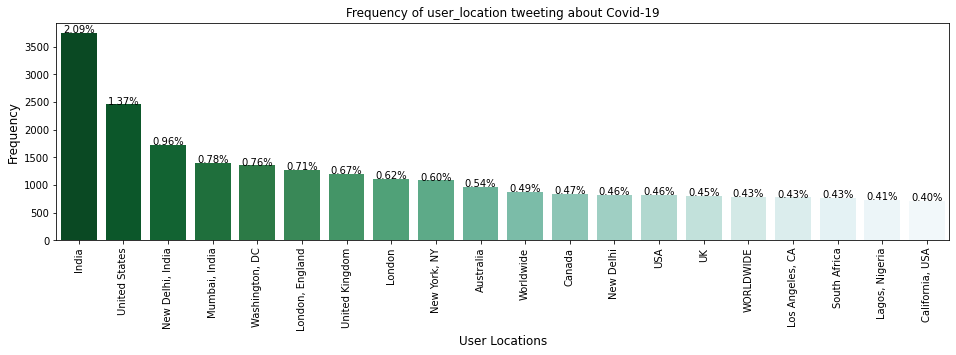

In [44]:
userloc_frequency_chart(covid_tweets_data, 'user_location', 'User Locations', 'BuGn_r')

This below pie chart shows us top 10 locations from where the tweets have been tweeted and their ratios on the locations.

In [63]:
import plotly.graph_objs as go
userloc_pie = pd.DataFrame(covid_tweets_data['user_location'].value_counts().sort_values(ascending=False))
userloc_pie = userloc_pie.rename(columns={'user_location':'count'})

In [64]:
data = {
   "values": userloc_pie['count'][:10],
   "labels": userloc_pie.index[:10],
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "type": "pie"
}
layout = go.Layout(title="<b>ratio on user_location</b>", legend=dict(x=1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

We are using a data visualization technique - Word Cloud to display `user_location` in a chart

In [92]:
from wordcloud import WordCloud, STOPWORDS
def wordcloud(string,title,color):
    wc = WordCloud(background_color=color, width=2000,height=1000,mask=None,random_state=1,
                   max_font_size=300,stopwords=stop_words,collocations=False).generate(string)
    fig=plt.figure(figsize=(40,16))
    plt.axis('off')
    plt.title('WordCloud for user_location',weight='bold', size=30)
    plt.imshow(wc)

In [93]:
# removes the most common stopwords
stop_words=set(STOPWORDS)
location_string = " ".join(covid_tweets_data['user_location'].astype('str'))

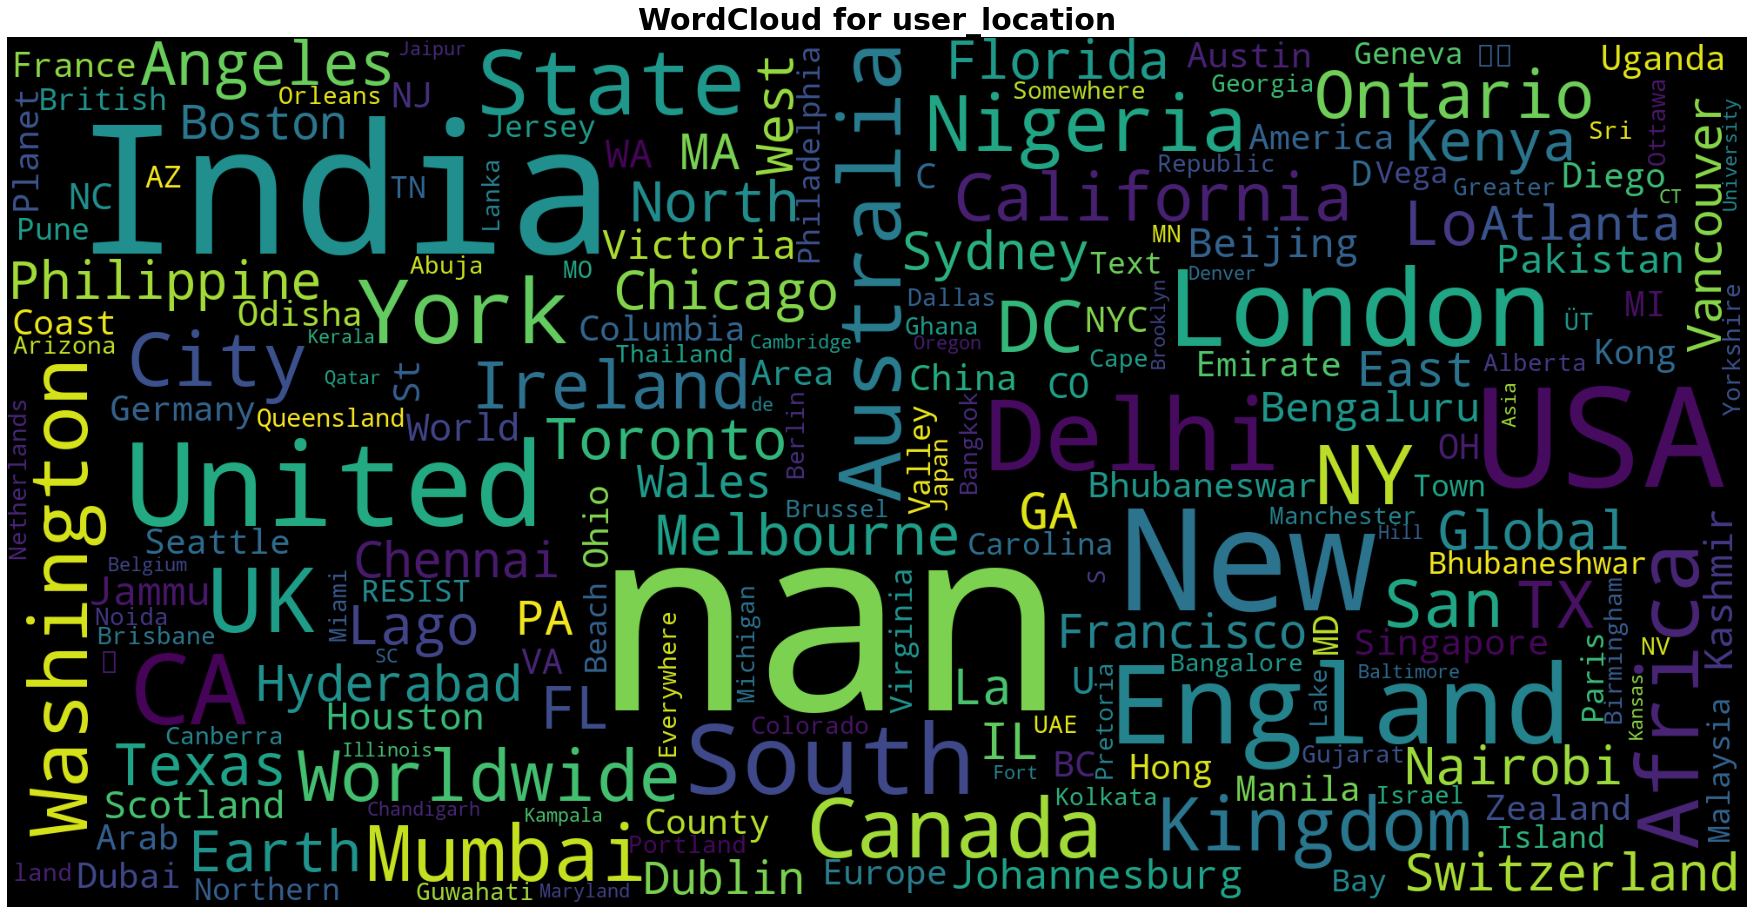

In [94]:
wordcloud(location_string,'location','black')